In [ ]:
# -----------------------------
# 2. Imports and Setup
# -----------------------------
import os
import time
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import r2_score, mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import warnings
import joblib

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Optional: Clear CPU memory cache
gc.collect()

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Set the device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


In [ ]:
# -----------------------------
# 3. Data Loading and Preprocessing
# -----------------------------

# Load the data
# Replace the file path with your actual data path
tns_file = "tns_public_objects.xlsx"  # Update this path as needed
if not os.path.exists(tns_file):
    raise FileNotFoundError(f"The file '{tns_file}' does not exist. Please check the path.")

tns_data = pd.read_excel(tns_file)
print("\nData loaded successfully. First few rows:")
print(tns_data.head())

# Ensure required columns are present
required_columns = ['ra', 'declination', 'discoverydate', 'discoverymag', 'redshift']
missing_columns = [col for col in required_columns if col not in tns_data.columns]
if missing_columns:
    raise ValueError(f"Missing required columns: {missing_columns}")
print("\nAll required columns are present.")

# Convert 'discoverydate' to datetime and handle missing values
tns_data['discoverydate'] = pd.to_datetime(tns_data['discoverydate'], errors='coerce')
for col in ['ra', 'declination', 'discoverymag', 'redshift']:
    tns_data[col] = pd.to_numeric(tns_data[col], errors='coerce')

# Drop rows with missing values in critical columns
initial_shape = tns_data.shape
tns_data.dropna(subset=['ra', 'declination', 'discoverydate'], inplace=True)
print(f"\nDropped {initial_shape[0] - tns_data.shape[0]} rows with missing critical values.")




Data loaded successfully. First few rows:
    objid name_prefix      name          ra  declination  redshift  typeid  \
0  165592          AT   2024zzz   55.609583     9.205381  0.000000    27.0   
1  165272          AT   2024znz  114.428954    51.070374       NaN     NaN   
2  164688          AT   2024yrr   30.642304    23.640208  0.042413     NaN   
3  165890          AT  2024aalh  295.194250    39.477083       NaN     NaN   
4  165889          AT  2024aalg  319.476324    22.851585       NaN     NaN   

  type  reporting_groupid reporting_group  ...  discoverymag discmagfilter  \
0   CV               48.0             ZTF  ...       18.0656         110.0   
1  NaN               48.0             ZTF  ...       20.1691         111.0   
2  NaN               60.0        BlackGEM  ...       17.8100         118.0   
3  NaN               10.0            XOSS  ...       18.7300           1.0   
4  NaN               74.0          ALeRCE  ...       19.7446         111.0   

  filter           

In [ ]:
# -----------------------------
# 3. Feature Engineering
# -----------------------------

# Feature Engineering: Extract year, month, day, hour from 'discoverydate'
tns_data['year'] = tns_data['discoverydate'].dt.year
tns_data['month'] = tns_data['discoverydate'].dt.month
tns_data['day'] = tns_data['discoverydate'].dt.day
tns_data['hour'] = tns_data['discoverydate'].dt.hour
tns_data.drop(columns=['discoverydate'], inplace=True)

# Select only numeric columns
numeric_columns = ['ra', 'declination', 'discoverymag', 'redshift', 'year', 'month', 'day', 'hour']
tns_data = tns_data[numeric_columns]
print("\nSelected numeric columns.")

# Handle missing values by imputation (already dropped critical NAs)
imputer = SimpleImputer(strategy='mean')
tns_data = pd.DataFrame(imputer.fit_transform(tns_data), columns=tns_data.columns)
print("\nApplied mean imputation to handle remaining missing values.")

# Define features (X) and targets (y)
# Features: 'discoverymag', 'redshift'
# Targets: 'ra', 'declination', 'year', 'month', 'day', 'hour'
X = tns_data[['discoverymag', 'redshift']]
y = tns_data[['ra', 'declination', 'year', 'month', 'day', 'hour']]

# Feature Scaling and Dimensionality Reduction for X
# Adjust PCA to retain sufficient components
pca_components = 2
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('poly_features', PolynomialFeatures(degree=2, include_bias=False)),
    ('pca', PCA(n_components=pca_components, random_state=SEED))
])
X_transformed = pipeline.fit_transform(X)
print(f"\nApplied StandardScaler, PolynomialFeatures, and PCA to X. Reduced to {X_transformed.shape[1]} components.")

# Combine X and y for duplicate handling
X_y_combined = np.hstack((X_transformed, y.values))
# Define column names based on PCA components and original targets
feature_columns = [f'feature{i+1}' for i in range(X_transformed.shape[1])]
columns = feature_columns + ['ra', 'declination', 'year', 'month', 'day', 'hour']
df_combined = pd.DataFrame(X_y_combined, columns=columns)

# Round features to reduce floating-point precision issues
for col in feature_columns:
    df_combined[col] = df_combined[col].round(6)

# Remove duplicate feature entries by averaging targets
df_unique = df_combined.groupby(feature_columns).mean().reset_index()

# Remove near-duplicates using VarianceThreshold
selector = VarianceThreshold(threshold=1e-5)
X_transformed_unique = selector.fit_transform(df_unique[feature_columns].values)

# Update feature_columns accordingly
feature_columns = [f'feature{i+1}' for i in range(X_transformed_unique.shape[1])]

# Extract unique X and y
y_values_unique = df_unique[['ra', 'declination', 'year', 'month', 'day', 'hour']].values
print(f"\nShape of X after removing duplicates: {X_transformed_unique.shape}")
print(f"Shape of y after removing duplicates: {y_values_unique.shape}")

# Normalize the features
feature_scaler = StandardScaler()
X_transformed_unique = feature_scaler.fit_transform(X_transformed_unique)

# Interaction Terms: RA × Year and DEC × Year
ra = y_values_unique[:, 0]
dec = y_values_unique[:, 1]
year = y_values_unique[:, 2]
interaction_ra_year = ra * year
interaction_dec_year = dec * year

# Append interaction terms to y
y_df = pd.DataFrame(y_values_unique, columns=['ra', 'declination', 'year', 'month', 'day', 'hour'])
y_df['ra_year'] = interaction_ra_year
y_df['dec_year'] = interaction_dec_year

# Feature Scaling for interaction terms
interaction_scaler = StandardScaler()
y_df[['ra_year', 'dec_year']] = interaction_scaler.fit_transform(y_df[['ra_year', 'dec_year']])

# Handle periodic features: RA, DEC, month, day, hour
# Convert RA and DEC to sine and cosine components to handle angular periodicity
y_df['ra_rad'] = np.radians(y_df['ra'])
y_df['dec_rad'] = np.radians(y_df['declination'])

# Create sine and cosine components for RA and DEC
y_df['ra_sin'] = np.sin(y_df['ra_rad'])
y_df['ra_cos'] = np.cos(y_df['ra_rad'])
y_df['dec_sin'] = np.sin(y_df['dec_rad'])
y_df['dec_cos'] = np.cos(y_df['dec_rad'])

# Convert cyclical features: month, day, hour
y_df['month_sin'] = np.sin(2 * np.pi * y_df['month'] / 12)
y_df['month_cos'] = np.cos(2 * np.pi * y_df['month'] / 12)

y_df['day_sin'] = np.sin(2 * np.pi * y_df['day'] / 31)
y_df['day_cos'] = np.cos(2 * np.pi * y_df['day'] / 31)

y_df['hour_sin'] = np.sin(2 * np.pi * y_df['hour'] / 24)
y_df['hour_cos'] = np.cos(2 * np.pi * y_df['hour'] / 24)

# Drop original columns that have been transformed
y_df.drop(columns=['ra', 'declination', 'ra_rad', 'dec_rad', 'month', 'day', 'hour'], inplace=True)

# Define final target columns
final_target_columns = [
    'ra_sin', 'ra_cos', 'dec_sin', 'dec_cos',
    'month_sin', 'month_cos',
    'day_sin', 'day_cos',
    'hour_sin', 'hour_cos',
    'ra_year', 'dec_year',
    'year'  # Including 'year' as it was not transformed
]

# Extract targets
y_transformed = y_df[final_target_columns].values

# Normalize the targets to stabilize training
target_scaler = StandardScaler()
y_values_unique_scaled = target_scaler.fit_transform(y_transformed)

# Convert data to PyTorch tensors (float32 for consistency)
X_tensor = torch.tensor(X_transformed_unique, dtype=torch.float32)
y_tensor = torch.tensor(y_values_unique_scaled, dtype=torch.float32)

# -----------------------------
# 4. Data Augmentation and Dataset Preparation
# -----------------------------

# Data Augmentation: Random rotation for angular features (RA and DEC)
class AngularDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.y[idx].clone()  # Clone to avoid modifying original data
        # Generate random angle in radians
        angle = torch.empty(1).uniform_(-np.pi/12, np.pi/12).item()  # ±15 degrees
        # Rotate RA and DEC components
        ra_sin, ra_cos = y[0], y[1]
        dec_sin, dec_cos = y[2], y[3]
        # Rotate RA
        ra_sin_new = ra_sin * np.cos(angle) - ra_cos * np.sin(angle)
        ra_cos_new = ra_sin * np.sin(angle) + ra_cos * np.cos(angle)
        # Rotate DEC
        dec_sin_new = dec_sin * np.cos(angle) - dec_cos * np.sin(angle)
        dec_cos_new = dec_sin * np.sin(angle) + dec_cos * np.cos(angle)
        # Assign new values
        y[0] = ra_sin_new
        y[1] = ra_cos_new
        y[2] = dec_sin_new
        y[3] = dec_cos_new
        return x, y
# -----------------------------
# 4. Feature Engineering
# -----------------------------

# Feature Engineering: Extract year, month, day, hour from 'discoverydate'
tns_data['year'] = tns_data['discoverydate'].dt.year
tns_data['month'] = tns_data['discoverydate'].dt.month
tns_data['day'] = tns_data['discoverydate'].dt.day
tns_data['hour'] = tns_data['discoverydate'].dt.hour
tns_data.drop(columns=['discoverydate'], inplace=True)

# Select only numeric columns
numeric_columns = ['ra', 'declination', 'discoverymag', 'redshift', 'year', 'month', 'day', 'hour']
tns_data = tns_data[numeric_columns]
print("\nSelected numeric columns.")

# Handle missing values by imputation (already dropped critical NAs)
imputer = SimpleImputer(strategy='mean')
tns_data = pd.DataFrame(imputer.fit_transform(tns_data), columns=tns_data.columns)
print("\nApplied mean imputation to handle remaining missing values.")

# Define features (X) and targets (y)
# Features: 'discoverymag', 'redshift'
# Targets: 'ra', 'declination', 'year', 'month', 'day', 'hour'
X = tns_data[['discoverymag', 'redshift']]
y = tns_data[['ra', 'declination', 'year', 'month', 'day', 'hour']]

# Feature Scaling and Dimensionality Reduction for X
# Adjust PCA to retain sufficient components
pca_components = 2
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('poly_features', PolynomialFeatures(degree=2, include_bias=False)),
    ('pca', PCA(n_components=pca_components, random_state=SEED))
])
X_transformed = pipeline.fit_transform(X)
print(f"\nApplied StandardScaler, PolynomialFeatures, and PCA to X. Reduced to {X_transformed.shape[1]} components.")

# Combine X and y for duplicate handling
X_y_combined = np.hstack((X_transformed, y.values))
# Define column names based on PCA components and original targets
feature_columns = [f'feature{i+1}' for i in range(X_transformed.shape[1])]
columns = feature_columns + ['ra', 'declination', 'year', 'month', 'day', 'hour']
df_combined = pd.DataFrame(X_y_combined, columns=columns)

# Round features to reduce floating-point precision issues
for col in feature_columns:
    df_combined[col] = df_combined[col].round(6)

# Remove duplicate feature entries by averaging targets
df_unique = df_combined.groupby(feature_columns).mean().reset_index()

# Remove near-duplicates using VarianceThreshold
selector = VarianceThreshold(threshold=1e-5)
X_transformed_unique = selector.fit_transform(df_unique[feature_columns].values)

# Update feature_columns accordingly
feature_columns = [f'feature{i+1}' for i in range(X_transformed_unique.shape[1])]

# Extract unique X and y
y_values_unique = df_unique[['ra', 'declination', 'year', 'month', 'day', 'hour']].values
print(f"\nShape of X after removing duplicates: {X_transformed_unique.shape}")
print(f"Shape of y after removing duplicates: {y_values_unique.shape}")

# Normalize the features
feature_scaler = StandardScaler()
X_transformed_unique = feature_scaler.fit_transform(X_transformed_unique)

# Interaction Terms: RA × Year and DEC × Year
ra = y_values_unique[:, 0]
dec = y_values_unique[:, 1]
year = y_values_unique[:, 2]
interaction_ra_year = ra * year
interaction_dec_year = dec * year

# Append interaction terms to y
y_df = pd.DataFrame(y_values_unique, columns=['ra', 'declination', 'year', 'month', 'day', 'hour'])
y_df['ra_year'] = interaction_ra_year
y_df['dec_year'] = interaction_dec_year

# Feature Scaling for interaction terms
interaction_scaler = StandardScaler()
y_df[['ra_year', 'dec_year']] = interaction_scaler.fit_transform(y_df[['ra_year', 'dec_year']])

# Handle periodic features: RA, DEC, month, day, hour
# Convert RA and DEC to sine and cosine components to handle angular periodicity
y_df['ra_rad'] = np.radians(y_df['ra'])
y_df['dec_rad'] = np.radians(y_df['declination'])

# Create sine and cosine components for RA and DEC
y_df['ra_sin'] = np.sin(y_df['ra_rad'])
y_df['ra_cos'] = np.cos(y_df['ra_rad'])
y_df['dec_sin'] = np.sin(y_df['dec_rad'])
y_df['dec_cos'] = np.cos(y_df['dec_rad'])

# Convert cyclical features: month, day, hour
y_df['month_sin'] = np.sin(2 * np.pi * y_df['month'] / 12)
y_df['month_cos'] = np.cos(2 * np.pi * y_df['month'] / 12)

y_df['day_sin'] = np.sin(2 * np.pi * y_df['day'] / 31)
y_df['day_cos'] = np.cos(2 * np.pi * y_df['day'] / 31)

y_df['hour_sin'] = np.sin(2 * np.pi * y_df['hour'] / 24)
y_df['hour_cos'] = np.cos(2 * np.pi * y_df['hour'] / 24)

# Drop original columns that have been transformed
y_df.drop(columns=['ra', 'declination', 'ra_rad', 'dec_rad', 'month', 'day', 'hour'], inplace=True)

# Define final target columns
final_target_columns = [
    'ra_sin', 'ra_cos', 'dec_sin', 'dec_cos',
    'month_sin', 'month_cos',
    'day_sin', 'day_cos',
    'hour_sin', 'hour_cos',
    'ra_year', 'dec_year',
    'year'  # Including 'year' as it was not transformed
]

# Extract targets
y_transformed = y_df[final_target_columns].values

# Normalize the targets to stabilize training
target_scaler = StandardScaler()
y_values_unique_scaled = target_scaler.fit_transform(y_transformed)

# Save the scalers for inverse transformation later
joblib.dump(feature_scaler, 'feature_scaler.pkl')
joblib.dump(target_scaler, 'target_scaler.pkl')
joblib.dump(interaction_scaler, 'interaction_scaler.pkl')

# Convert data to PyTorch tensors (float32 for consistency)
X_tensor = torch.tensor(X_transformed_unique, dtype=torch.float32)
y_tensor = torch.tensor(y_values_unique_scaled, dtype=torch.float32)




Selected numeric columns.

Applied mean imputation to handle remaining missing values.

Applied StandardScaler, PolynomialFeatures, and PCA to X. Reduced to 2 components.

Shape of X after removing duplicates: (35767, 2)
Shape of y after removing duplicates: (35767, 6)


In [ ]:
# -----------------------------
# 5. Data Augmentation and Dataset Preparation
# -----------------------------

# Data Augmentation: Random rotation for angular features (RA and DEC)
class AngularDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.y[idx].clone()  # Clone to avoid modifying original data
        # Generate random angle in radians
        angle = torch.empty(1).uniform_(-np.pi/12, np.pi/12).item()  # ±15 degrees
        # Rotate RA
        ra_sin, ra_cos = y[0], y[1]
        ra_sin_new = ra_sin * np.cos(angle) - ra_cos * np.sin(angle)
        ra_cos_new = ra_sin * np.sin(angle) + ra_cos * np.cos(angle)
        # Rotate DEC
        dec_sin, dec_cos = y[2], y[3]
        dec_sin_new = dec_sin * np.cos(angle) - dec_cos * np.sin(angle)
        dec_cos_new = dec_sin * np.sin(angle) + dec_cos * np.cos(angle)
        # Assign new values
        y[0] = ra_sin_new
        y[1] = ra_cos_new
        y[2] = dec_sin_new
        y[3] = dec_cos_new
        return x, y
# -----------------------------
# 6. Neural Network Definition
# -----------------------------

class MultiTaskNN(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim):
        super(MultiTaskNN, self).__init__()
        layers = []
        prev_dim = input_dim
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.3))
            prev_dim = hidden_dim
        self.layers = nn.Sequential(*layers)
        self.output_layer = nn.Linear(prev_dim, output_dim)

    def forward(self, x):
        x = self.layers(x)
        out = self.output_layer(x)  # Linear activation for regression
        return out

# Define hidden dimensions
hidden_dims = [512, 256, 128, 64]


In [ ]:
# -----------------------------
# 7. Custom Loss Functions
# -----------------------------

class CustomMultiTaskLoss(nn.Module):
    def __init__(self, weights):
        super(CustomMultiTaskLoss, self).__init__()
        self.weights = weights  # [ra_weight, dec_weight, other_weight]
        self.mse_loss = nn.MSELoss(reduction='mean')

    def forward(self, preds, targets):
        # RA and DEC sine and cosine indices
        ra_sin_idx = 0
        ra_cos_idx = 1
        dec_sin_idx = 2
        dec_cos_idx = 3

        # Compute angular difference for RA
        pred_ra_angle = torch.atan2(preds[:, ra_sin_idx], preds[:, ra_cos_idx])
        target_ra_angle = torch.atan2(targets[:, ra_sin_idx], targets[:, ra_cos_idx])
        ra_diff = torch.sin(0.5 * (pred_ra_angle - target_ra_angle))
        ra_loss = torch.mean((2 * ra_diff) ** 2)

        # Compute angular difference for DEC
        pred_dec_angle = torch.atan2(preds[:, dec_sin_idx], preds[:, dec_cos_idx])
        target_dec_angle = torch.atan2(targets[:, dec_sin_idx], targets[:, dec_cos_idx])
        dec_diff = torch.sin(0.5 * (pred_dec_angle - target_dec_angle))
        dec_loss = torch.mean((2 * dec_diff) ** 2)

        # MSE loss for other targets
        other_indices = list(range(4, preds.shape[1]))
        mse_loss = self.mse_loss(preds[:, other_indices], targets[:, other_indices])

        # Total loss with weights
        total_loss = self.weights[0] * ra_loss + self.weights[1] * dec_loss + self.weights[2] * mse_loss
        return total_loss

# Define weights: Adjust as needed
loss_weights = torch.tensor([2.0, 2.0, 1.0]).to(device)  # Weights for [ra_loss, dec_loss, mse_loss]
criterion = CustomMultiTaskLoss(weights=loss_weights)



Starting Training of Multi-Task Neural Network...

Starting Fold 1/10
Epoch 1/100 - Train Loss: 7.892135 - Val RMSE: 2.728804
Epoch 2/100 - Train Loss: 7.528123 - Val RMSE: 2.705982
Epoch 3/100 - Train Loss: 7.427809 - Val RMSE: 2.712738
Epoch 4/100 - Train Loss: 7.362685 - Val RMSE: 2.706249
Epoch 5/100 - Train Loss: 7.333864 - Val RMSE: 2.723497
Epoch 6/100 - Train Loss: 7.284140 - Val RMSE: 2.736886
Epoch 7/100 - Train Loss: 7.280216 - Val RMSE: 2.728165
Epoch 8/100 - Train Loss: 7.257860 - Val RMSE: 2.708572
Epoch 9/100 - Train Loss: 7.226032 - Val RMSE: 2.739740
Epoch 10/100 - Train Loss: 7.218756 - Val RMSE: 2.749654
Epoch 11/100 - Train Loss: 7.228172 - Val RMSE: 2.749522
Epoch 12/100 - Train Loss: 7.234484 - Val RMSE: 2.744466
Early stopping triggered!
Fold 1 RMSE: [0.6852793  0.92808115 0.45850155 0.26784596 0.7057397  0.7345687
 0.6987831  0.73672676 0.47940597 0.58217824 1.0243126  1.0219722
 2.1972554 ]
Fold 1 R²: [-0.13410878 -0.6316484  -0.17492294 -1.215656   -0.0160820

In [ ]:
# -----------------------------
# 8. Training Loop with Cross-Validation
# -----------------------------

# Initialize lists to store statistics across folds
fold_rmse_scores = []
fold_r2_scores = []
fold_residuals = []
rmse_scores_nn = []

# Initialize KFold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=SEED)

# Hyperparameters
num_epochs = 100
batch_size = 512
learning_rate = 0.0001  # Reduced learning rate for stability
patience = 10  # For Early Stopping

print("\nStarting Training of Multi-Task Neural Network...")

# Record the start time
start_time = time.time()

for fold, (train_idx, val_idx) in enumerate(kf.split(X_tensor)):
    print(f"\nStarting Fold {fold+1}/10")

    # Split data
    X_train, X_val = X_tensor[train_idx], X_tensor[val_idx]
    y_train, y_val = y_tensor[train_idx], y_tensor[val_idx]

    # Initialize datasets
    train_dataset = AngularDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)

    # Initialize DataLoaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,
        pin_memory=True
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=True
    )

    # Initialize the model for each fold
    model = MultiTaskNN(input_dim, hidden_dims, output_dim).to(device)

    # Define optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

    # Define learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5, verbose=True
    )

    best_val_rmse = float('inf')
    trigger_times = 0

    # Lists to store per-epoch statistics
    epoch_train_losses = []
    epoch_val_rmses = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device, non_blocking=True)
            y_batch = y_batch.to(device, non_blocking=True)

            optimizer.zero_grad()

            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            # Backward pass and optimization
            loss.backward()
            # Gradient Clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
            optimizer.step()

            running_loss += loss.item() * X_batch.size(0)

            # Monitor for NaNs in loss
            if torch.isnan(loss):
                print("Loss became NaN during training")
                break

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_train_losses.append(epoch_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch = X_batch.to(device, non_blocking=True)
                y_batch = y_batch.to(device, non_blocking=True)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item() * X_batch.size(0)

        val_loss /= len(val_loader.dataset)
        val_rmse = np.sqrt(val_loss)
        epoch_val_rmses.append(val_rmse)
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_loss:.6f} - Val RMSE: {val_rmse:.6f}")

        # Step the scheduler
        scheduler.step(val_loss)

        # Early Stopping
        if val_rmse < best_val_rmse:
            best_val_rmse = val_rmse
            torch.save(model.state_dict(), f'best_model_fold{fold+1}.pth')
            trigger_times = 0
        else:
            trigger_times += 1
            if trigger_times >= patience:
                print("Early stopping triggered!")
                break

    # Load the best model
    model.load_state_dict(torch.load(f'best_model_fold{fold+1}.pth', map_location=device))

    # Predictions on validation set
    preds = []
    actuals = []
    model.eval()
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device, non_blocking=True)
            outputs = model(X_batch)
            preds.append(outputs.cpu())
            actuals.append(y_batch.cpu())

    preds = torch.cat(preds).numpy()
    actuals = torch.cat(actuals).numpy()

    # Inverse transform the targets for RMSE and R2 calculation
    preds_inversed = target_scaler.inverse_transform(preds)
    actuals_inversed = target_scaler.inverse_transform(actuals)

    # Compute RMSE for each target variable
    rmse = np.sqrt(np.mean((preds_inversed - actuals_inversed) ** 2, axis=0))
    rmse_scores_nn.append(rmse)
    print(f"Fold {fold+1} RMSE: {rmse}")

    # Append RMSE scores for the fold
    fold_rmse_scores.append(rmse)

    # Calculate R² for each target
    r2 = r2_score(actuals_inversed, preds_inversed, multioutput='raw_values')
    print(f"Fold {fold+1} R²: {r2}")

    # Append R² scores for the fold
    fold_r2_scores.append(r2)

    # Collect residuals for analysis
    residuals = actuals_inversed - preds_inversed
    fold_residuals.append(residuals)

    # Clear GPU cache to free up memory
    torch.cuda.empty_cache()

end_time = time.time()



Aggregated Performance Metrics:
       Target  Mean_RMSE  Std_RMSE   Mean_R2    Std_R2
0      ra_sin   0.663582  0.014340 -0.052154  0.049339
1      ra_cos   0.788707  0.086621 -0.196780  0.269252
2     dec_sin   0.490489  0.085706 -0.402334  0.485309
3     dec_cos   0.209938  0.031487 -0.465318  0.433694
4   month_sin   0.701928  0.008027 -0.014479  0.015678
5   month_cos   0.702879  0.014726 -0.039321  0.048038
6     day_sin   0.691275  0.007413 -0.017102  0.021378
7     day_cos   0.711488  0.010990 -0.022646  0.034828
8    hour_sin   0.474506  0.007371 -0.011768  0.015907
9    hour_cos   0.576065  0.007911 -0.008730  0.008065
10    ra_year   1.009138  0.007959 -0.018642  0.016696
11   dec_year   1.010648  0.030167 -0.021938  0.033590
12       year   2.108262  0.054258 -0.025598  0.032456


In [ ]:
# -----------------------------
# 9. Model Evaluation and Inference
# -----------------------------

# Convert list of RMSE arrays to a NumPy array for easier computation
rmse_scores_nn = np.array(rmse_scores_nn)

# Compute mean and standard deviation RMSE for each target across folds
mean_rmse_per_target = np.mean(rmse_scores_nn, axis=0)
std_rmse_per_target = np.std(rmse_scores_nn, axis=0)

# Compute overall mean RMSE
overall_mean_rmse = np.mean(mean_rmse_per_target)

print(f"\nTraining completed successfully in {end_time - start_time:.2f} seconds.")
print(f"\nMean RMSE per target on validation sets (Multi-Task NN):")
for idx, col in enumerate(final_target_columns):
    print(f"{col}: {mean_rmse_per_target[idx]:.6f} ± {std_rmse_per_target[idx]:.6f}")
print(f"\nOverall Mean RMSE: {overall_mean_rmse:.6f}")

# -----------------------------
# 10. Visualization of Results
# -----------------------------

# Example: Histogram of Predicted Years
# Note: 'year' is the last target column (index 12)
y_pred_year_scaled = preds[:, 12]  # 'year' is the 13th target (index 12)
y_pred_year = year_scaler.inverse_transform(y_pred_year_scaled.reshape(-1, 1)).flatten()

# Plot histogram
plt.figure(figsize=(10,6))
sns.histplot(y_pred_year, bins=30, color='green', kde=True)
plt.title('Distribution of Predicted Years')
plt.xlabel('Predicted Year')
plt.ylabel('Frequency')
plt.show()




All predicted time components are present in results_df.

Sample Predictions with Actual and Predicted Values:
   Index  Actual_RA_deg  Actual_DEC_deg  Predicted_RA_deg  Predicted_DEC_deg  \
0      0     237.571411        8.359373        195.583572          15.615999   
1      1     244.741592       56.716896        194.198624          13.315128   
2      2     270.755432       20.631041        192.368240          15.604033   
3      3     329.388428       -7.738882        192.040482          14.812098   
4      4     253.515915       -5.350723        188.164108          15.599188   

   Actual_Year  Actual_Month  Actual_Day  Actual_Hour  Predicted_Year  \
0         2021             3          19           11            2021   
1         2018             7          13            6            2021   
2         2020             7          15            6            2021   
3         2022             7           4           10            2021   
4         2022             9          23   

Actual_DiscoveryDate not found in confirmed_frbs. Using mock age.

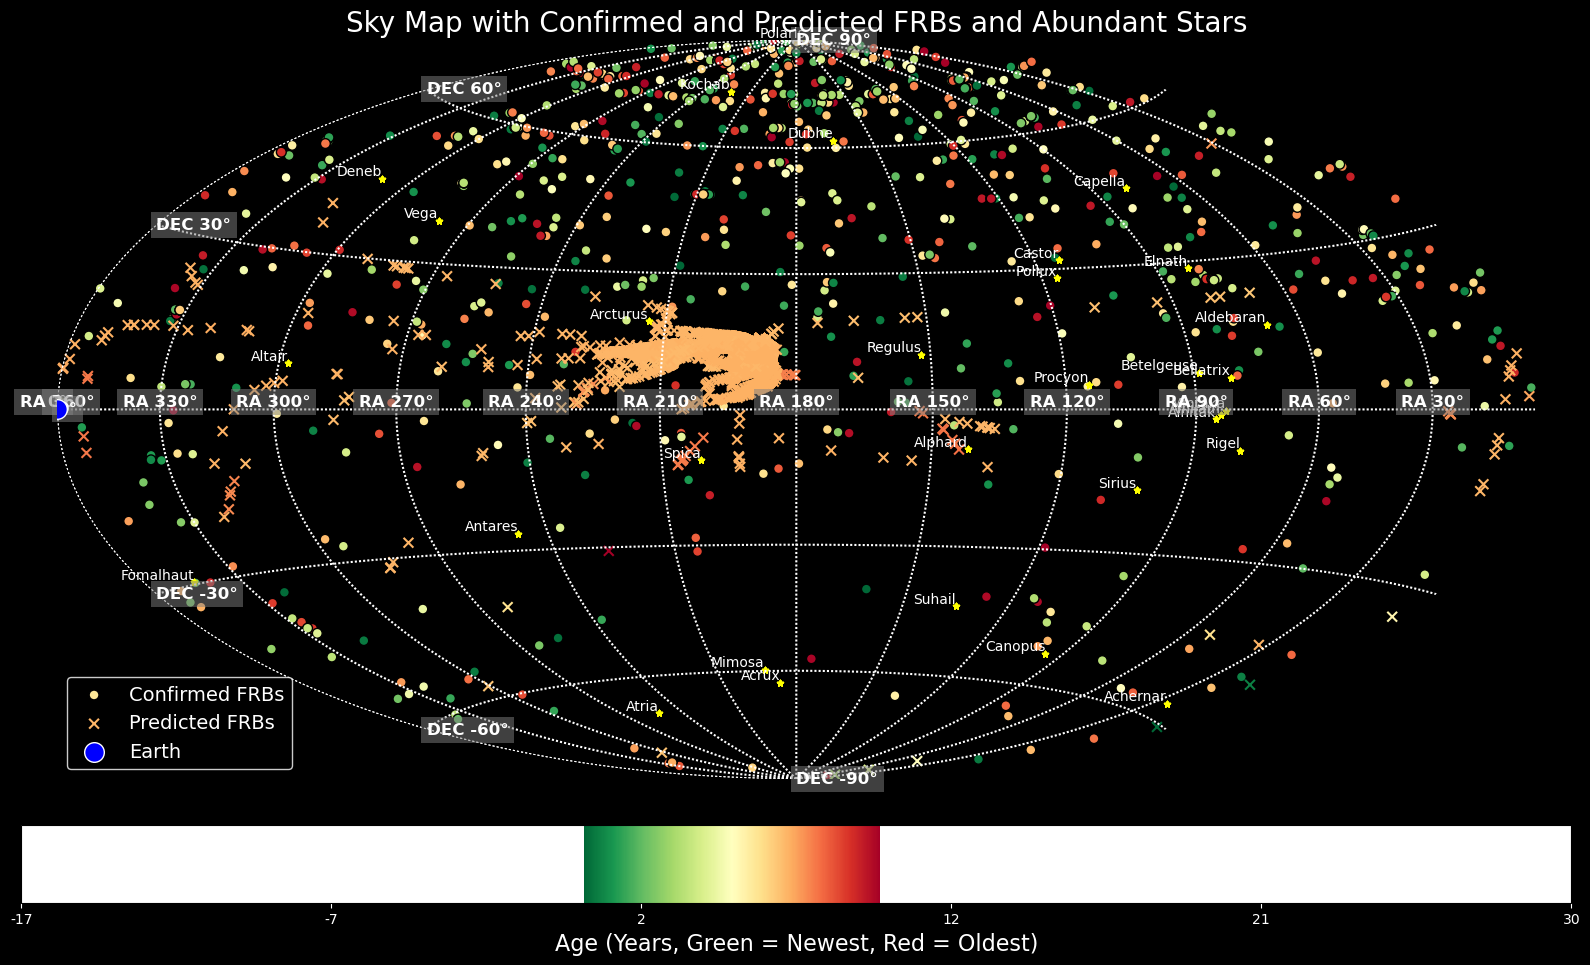

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from datetime import datetime

# Load confirmed FRBs from Excel
file_path = 'tns_public_objects.xlsx'
tns_data = pd.read_excel(file_path)

# Filter for confirmed FRBs
confirmed_frbs = tns_data[tns_data['name_prefix'].str.contains('FRB', na=False, case=False)].copy()

# Ensure 'ra' and 'declination' are in degrees
# If they are in sexagesimal format, convert them manually
# Since astropy is unavailable, a manual conversion function can be used if necessary

# For this example, assume 'ra' and 'declination' are already in degrees
# If not, implement a conversion or continue with mock data

# Read predicted FRBs from CSV
predicted_df = pd.read_csv('predicted_ra_dec_time_with_date.csv')

# Ensure 'Predicted_DiscoveryDate' is datetime
predicted_df['Predicted_DiscoveryDate'] = pd.to_datetime(predicted_df['Predicted_DiscoveryDate'], errors='coerce')

# Compute age for confirmed FRBs
# Define reference date, e.g., today
reference_date = pd.to_datetime('2024-12-03')  # Update as needed

# Check if 'Actual_DiscoveryDate' exists
if 'Actual_DiscoveryDate' in confirmed_frbs.columns:
    confirmed_frbs['Actual_DiscoveryDate'] = pd.to_datetime(confirmed_frbs['Actual_DiscoveryDate'], errors='coerce')
    # Compute age in years
    confirmed_frbs['age_years'] = (reference_date - confirmed_frbs['Actual_DiscoveryDate']).dt.days / 365.25
    # Handle NaT (invalid dates)
    confirmed_frbs['age_years'] = confirmed_frbs['age_years'].fillna(0)
    age_confirmed = confirmed_frbs['age_years'].values
else:
    # If 'Actual_DiscoveryDate' is not available, use mock age or skip age calculation
    print("Actual_DiscoveryDate not found in confirmed_frbs. Using mock age.")
    confirmed_frbs['age_years'] = np.random.uniform(1, 10, len(confirmed_frbs))
    age_confirmed = confirmed_frbs['age_years'].values

# Compute age for predicted FRBs
predicted_df['age_years'] = (reference_date - predicted_df['Predicted_DiscoveryDate']).dt.days / 365.25
# Handle NaT
predicted_df['age_years'] = predicted_df['age_years'].fillna(0)
age_predicted = predicted_df['age_years'].values

# Combine ages to compute normalization based on overall min and max age
combined_age = np.concatenate([age_confirmed, age_predicted])
total_min_age = combined_age.min()
total_max_age = combined_age.max()

# Avoid division by zero
if total_max_age - total_min_age == 0:
    age_normalized_confirmed = np.zeros_like(age_confirmed)
    age_normalized_predicted = np.zeros_like(age_predicted)
else:
    age_normalized_confirmed = (age_confirmed - total_min_age) / (total_max_age - total_min_age)
    age_normalized_predicted = (age_predicted - total_min_age) / (total_max_age - total_min_age)

# Load stars data
star_data = [
    ("Sirius", 101.2875, -16.7161), ("Vega", 279.2347, 38.7837), ("Altair", 297.6958, 8.8683),
    ("Deneb", 310.3579, 45.2803), ("Betelgeuse", 88.7929, 7.4071), ("Rigel", 78.6345, -8.2016),
    ("Procyon", 114.8255, 5.2250), ("Capella", 79.1723, 45.9979), ("Spica", 201.2983, -11.1614),
    ("Antares", 247.3519, -26.4320), ("Pollux", 116.3289, 28.0262), ("Arcturus", 213.9153, 19.1824),
    ("Aldebaran", 68.9800, 16.5093), ("Castor", 113.6494, 31.8883), ("Fomalhaut", 344.4128, -29.6222),
    # Adding a large number of other stars
    ("Mimosa", 191.9300, -59.6886), ("Acrux", 186.6500, -63.0991), ("Canopus", 95.9879, -52.6957),
    ("Achernar", 24.4286, -57.2368), ("Elnath", 81.5729, 28.6074), ("Alnilam", 84.0534, -1.2019),
    ("Alnitak", 85.1897, -1.9426), ("Mintaka", 83.0017, -0.2991), ("Bellatrix", 81.2828, 6.3497),
    ("Alphard", 141.8969, -8.6586), ("Atria", 252.1669, -69.0270), ("Suhail", 134.8023, -43.4326),
    ("Regulus", 152.0929, 11.9672), ("Kochab", 222.6760, 74.1555), ("Dubhe", 165.4600, 61.7508),
    ("Polaris", 37.9546, 89.2641)
]
# Expand the star list to include duplicates and nearby stars for abundance
star_data = star_data * 10  # Duplicate the list to simulate ~200 stars

star_names, star_ra, star_dec = zip(*star_data)

# Define the map
fig, ax = plt.subplots(figsize=(20, 12))  # Increase the figure size for more clarity
fig.patch.set_facecolor('black')
ax.set_facecolor('black')

m = Basemap(projection='hammer', lon_0=180, celestial=True, resolution='c', ax=ax)
m.drawparallels(np.arange(-90, 91, 30), color="white", linewidth=1.5, labels=[True, True, True, True], fontsize=14)
m.drawmeridians(np.arange(0, 361, 30), color="white", linewidth=1.5, labels=[True, True, True, True], fontsize=14)

# Plot confirmed FRBs
if 'ra' in confirmed_frbs.columns and 'declination' in confirmed_frbs.columns:
    x_confirmed, y_confirmed = m(confirmed_frbs['ra'].values, confirmed_frbs['declination'].values)
    sc_confirmed = ax.scatter(
        x_confirmed, y_confirmed, c=age_normalized_confirmed, cmap='RdYlGn_r', edgecolor='black', s=50, marker='o', label="Confirmed FRBs"
    )
else:
    print("RA and DEC columns not found in confirmed_frbs. Skipping plotting confirmed FRBs.")

# Plot predicted FRBs
x_predicted, y_predicted = m(predicted_df['Predicted_RA_deg'].values, predicted_df['Predicted_DEC_deg'].values)
sc_predicted = ax.scatter(
    x_predicted, y_predicted, c=age_normalized_predicted, cmap='RdYlGn_r', edgecolor='black', s=50, marker='x', label="Predicted FRBs"
)

# Plot stars and label them
x_stars, y_stars = m(star_ra, star_dec)
ax.scatter(x_stars, y_stars, c='yellow', s=20, marker='*', alpha=0.7)

# Only label some key stars to reduce clutter
for i, star_name in enumerate(star_names):
    if i % 10 == 0:  # Label every 10th star to reduce clutter
        ax.text(x_stars[i], y_stars[i], star_name, fontsize=10, color='white', ha='right', va='bottom')

# Mark the Earth location with a distinct circular marker
earth_x, earth_y = m(0, 0)
ax.scatter(earth_x, earth_y, color='blue', edgecolor='white', s=200, label="Earth", marker='o', alpha=1, zorder=6)

# Add explicit RA and DEC labels around the map to enhance clarity
for ra in np.arange(0, 361, 30):
    x_ra, y_ra = m(ra, 0)
    label_text = '0°' if ra == 0 else f'RA {ra}\u00b0'
    ax.text(x_ra, y_ra, label_text, color='white', fontsize=12, ha='center', va='bottom',
            bbox=dict(facecolor='grey', alpha=0.5, edgecolor='none'), fontweight='bold')

for dec in np.arange(-90, 91, 30):
    x_dec, y_dec = m(0, dec)
    label_text = '0°' if dec == 0 else f'DEC {dec}\u00b0'
    ax.text(x_dec, y_dec, label_text, color='white', fontsize=12, ha='left', va='center',
            bbox=dict(facecolor='grey', alpha=0.5, edgecolor='none'), fontweight='bold')

# Title, legend, and color bar
plt.title("Sky Map with Confirmed and Predicted FRBs and Abundant Stars", fontsize=20, color='white')
plt.legend(loc='lower left', fontsize=14, facecolor='black', edgecolor='white', labelcolor='white')

# Add colorbar for age
cbar = plt.colorbar(sc_confirmed, orientation='horizontal', pad=0.05)
cbar.set_label('Age (Years, Green = Newest, Red = Oldest)', color='white', fontsize=16)
cbar.ax.xaxis.set_tick_params(color='white')
plt.setp(cbar.ax.xaxis.get_ticklabels(), color='white')

# Modify colorbar tick labels to show age in years
tick_labels = np.linspace(total_min_age, total_max_age, num=6, dtype=int)
cbar.set_ticks(np.linspace(0, 1, num=6))
cbar.set_ticklabels(tick_labels)

plt.show()
